## 04_GriddedDiagnostics_Frontogenesis_CFSR: Compute derived quantities using MetPy

## In this notebook, we'll cover the following:
1. Select a date and access various CFSR Datasets
2. Subset the desired Datasets along their dimensions
3. Calculate and visualize frontogenesis.
4. Smooth the diagnostic field.

# <span style="color:purple">0) Preliminaries </span>

In [71]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# <span style="color:purple">1) Specify a starting and ending date/time, and access several CFSR Datasets</span>

In [72]:
startYear = 1993
startMonth = 3
startDay = 14
startHour = 0
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 1993
endMonth = 3
endDay = 14
endHour = 12
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)


### Create Xarray `Dataset` objects

In [73]:
dsZ = xr.open_dataset ('/cfsr/data/%s/g.%s.0p5.anl.nc' % (startYear, startYear))
dsT = xr.open_dataset ('/cfsr/data/%s/t.%s.0p5.anl.nc' % (startYear, startYear))
dsU = xr.open_dataset ('/cfsr/data/%s/u.%s.0p5.anl.nc' % (startYear, startYear))
dsV = xr.open_dataset ('/cfsr/data/%s/v.%s.0p5.anl.nc' % (startYear, startYear))
dsW = xr.open_dataset ('/cfsr/data/%s/w.%s.0p5.anl.nc' % (startYear, startYear))
dsQ = xr.open_dataset ('/cfsr/data/%s/q.%s.0p5.anl.nc' % (startYear, startYear))
dsSLP = xr.open_dataset ('/cfsr/data/%s/pmsl.%s.0p5.anl.nc' % (startYear, startYear))

# <span style="color:purple">2) Specify a date/time range, and subset the desired `Dataset`s along their dimensions.</span>

Create a list of date and times based on what we specified for the initial and final times, using Pandas' date_range function

In [74]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6H")
dateList

DatetimeIndex(['1993-03-14 00:00:00', '1993-03-14 06:00:00',
               '1993-03-14 12:00:00'],
              dtype='datetime64[ns]', freq='6H')

In [75]:
# Areal extent
lonW = -90
lonE = -60
latS = 35
latN = 50
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
latRange = np.arange(latS,latN+.5,.5) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE+.5,.5) # Need to match longitude values to those of the coordinate variable

Specify the pressure level. 

In [76]:
# Vertical level specificaton
pLevel = 850
levStr = f'{pLevel}'

We will display temperature and wind (and ultimately, temperature advection), so pick the relevant variables.

### Now create objects for our desired DataArrays based on the coordinates we have subsetted.

In [77]:
# Data variable selection
T = dsT['t'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)
U = dsU['u'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)
V = dsV['v'].sel(time=dateList,lev=pLevel,lat=latRange,lon=lonRange)

Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.

In [78]:
lats = T.lat
lons = T.lon

# <span style="color:purple">3) Calculate and visualize 2-dimensional frontogenesis.</span>

### In order to calculate many meteorologically-relevant quantities that depend on distances between gridpoints, we need horizontal distance between gridpoints in meters. MetPy can infer this from datasets such as our CFSR that are lat-lon based, but we need to explicitly assign a coordinate reference system first.

In [79]:
crsCFSR = {'grid_mapping_name': 'latitude_longitude', 'earth_radius': 6371229.0}
T = T.metpy.assign_crs(crsCFSR)
U = U.metpy.assign_crs(crsCFSR)
V = V.metpy.assign_crs(crsCFSR)

#### Unit conversions

In [80]:
UKts = U.metpy.convert_units('kts')
VKts = V.metpy.convert_units('kts')

In [81]:
constrainLat, constrainLon = (0.5, 4.0)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

#### Let's explore the `frontogenesis` diagnostic: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.frontogenesis.html

#### We first need to compute [potential temperature](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.potential_temperature.html). First, let's attach units to our chosen pressure level, so that MetPy can calculate potential temperature accordingly.

In [82]:
#Attach units to pLevel for use in MetPy with new variable, P:
P = pLevel*units['hPa']

#### Now calculate potential temperature, and verify that it looks reasonable.

In [83]:
Thta = mpcalc.potential_temperature(P, T)

In [84]:
Thta

Magnitude,[[[272.4622802734375 272.2527770996094 272.1480407714844 ... 297.8125 297.49822998046875 297.2887268066406] [271.9385070800781 271.624267578125 271.4147644042969 ... 297.3934631347656 297.0792236328125 296.76495361328125] [271.30999755859375 270.8909912109375 270.7862243652344 ... 296.9744567871094 296.66021728515625 296.3459167480469] ... [262.1965026855469 262.09173583984375 261.8822326660156 ... 269.6339416503906 269.5292053222656 269.5292053222656] [262.406005859375 262.09173583984375 261.5679626464844 ... 268.7959289550781 268.691162109375 268.58642578125] [262.5107421875 261.98699951171875 261.5679626464844 ... 266.9103698730469 266.80560302734375 266.80560302734375]] [[272.2527770996094 271.72900390625 271.2052307128906 ... 297.7077331542969 297.917236328125 297.917236328125] [271.624267578125 271.1004943847656 270.5767517089844 ... 297.0792236328125 297.3934631347656 297.60296630859375] [271.1004943847656 270.5767517089844 269.9482116699219 ... 296.45068359375 296.76495361328125 297.1839599609375] ... [262.5107421875 262.5107421875 262.406005859375 ... 270.47198486328125 270.7862243652344 270.8909912109375] [262.406005859375 262.1965026855469 261.98699951171875 ... 269.73870849609375 269.84344482421875 270.052978515625] [262.3012390136719 262.09173583984375 261.8822326660156 ... 268.90069580078125 269.0054626464844 269.11016845703125]] [[273.30029296875 272.4622802734375 271.8337707519531 ... 297.2887268066406 297.1839599609375 297.1839599609375] [272.5670471191406 271.8337707519531 271.2052307128906 ... 297.2887268066406 296.9744567871094 296.86968994140625] [271.9385070800781 271.2052307128906 270.5767517089844 ... 297.2887268066406 296.9744567871094 296.66021728515625] ... [261.7774963378906 261.8822326660156 261.7774963378906 ... 272.4622802734375 271.2052307128906 269.73870849609375] [261.6727294921875 261.7774963378906 261.5679626464844 ... 268.7959289550781 268.7959289550781 268.3769226074219] [261.6727294921875 261.6727294921875 261.5679626464844 ... 268.0626525878906 268.3769226074219 268.7959289550781]]]
Units,kelvin


#### Now calculate frontogenesis, and examine the output `DataArray`.

In [85]:
frnt = mpcalc.frontogenesis(Thta, U, V)
frnt

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/pint/quantity.py:1313: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Magnitude,[[[2.0450913998970095e-10 1.0664012964552562e-10 5.40849360823641e-11 ... 3.1960834181548323e-11 -7.300938606733038e-11 -2.1713055131694314e-10] [3.4504503912999624e-10 2.1682773564196087e-10 6.300477601640942e-11 ... -3.591948919149954e-12 -4.642995376165739e-11 -6.229636583010547e-11] [5.172023995734236e-10 2.2628129131235407e-10 -1.116145334768999e-11 ... -8.567194928384269e-11 3.442964323207559e-12 5.288025798223365e-11] ... [-9.648512884657496e-12 -6.824921263253097e-11 -6.901911306793033e-11 ... 1.600074665353076e-10 1.6040838635240203e-10 1.5070294242612513e-10] [-2.497992990990776e-12 5.6449448779122854e-11 1.7878724294298373e-10 ... 7.84867540310552e-10 7.623615613181643e-10 7.876071134636841e-10] [5.957146886507466e-11 1.6423498259598994e-10 7.755106559764353e-11 ... 9.74359798315445e-10 1.209905584972841e-09 1.1685779348820483e-09]] [[2.3680334757615823e-10 1.7715937888842582e-10 1.5156782539858657e-10 ... -4.91325320455737e-10 -3.182597152120781e-10 3.003385353845468e-12] [4.5271466385729166e-11 5.312713162396201e-11 7.212556153137261e-11 ... -5.53606638983848e-10 -5.338303743476669e-10 -2.647757699744254e-10] [5.025993576422602e-12 -1.1856774438603168e-11 -4.5011704453057106e-11 ... -4.0148624975510824e-10 -6.68598225194188e-10 -4.673095614869056e-10] ... [-3.5062652040428794e-11 -1.1123532759116342e-10 -7.75602703995451e-11 ... 1.1349983964748503e-09 1.046210592352074e-09 8.2414104914707e-10] [3.557444032372768e-11 -3.200964218197284e-11 -5.3569198660395486e-11 ... 6.854370786815945e-10 7.876555721976602e-10 7.284269881978164e-10] [2.1005839605318558e-11 7.380227423967451e-11 9.331109828307171e-11 ... 7.470193198770075e-10 7.046868417235747e-10 9.79454293208136e-10]] [[-6.003942036903277e-10 -2.915306348996794e-10 -1.2568303858988088e-10 ... 3.1285403823008326e-10 -1.5812847323175426e-10 -2.9607267164012425e-10] [-6.387024660463707e-10 -4.364578326670007e-10 -2.5124335633481635e-10 ... 3.2517808748555745e-10 1.326488859197197e-10 -1.5120862435406532e-10] [-7.233455044659619e-10 -5.404161686460373e-10 -2.2497815964461664e-10 ... 2.749202703686278e-10 2.420537872935267e-10 1.9123927738970828e-10] ... [9.069820507829429e-11 5.082638172129369e-12 -7.212885215660894e-11 ... 1.1501551166688977e-08 6.641332998502744e-09 4.331492239952058e-09] [1.3752306664474487e-10 -4.062890937873811e-11 -4.8638653995432604e-11 ... 5.30211430092723e-09 2.1051342877351138e-09 -8.793773982674734e-10] [-1.419455282205478e-11 -4.16932090967472e-11 1.3231844624872771e-10 ... 7.183972804026234e-10 3.5661929958656343e-10 1.210741539965459e-09]]]
Units,kelvin/(meter second)


Let's get a quick visualization, using Xarray's built-in interface to Matplotlib.

AttributeError: 'Rectangle' object has no property 'cmap'

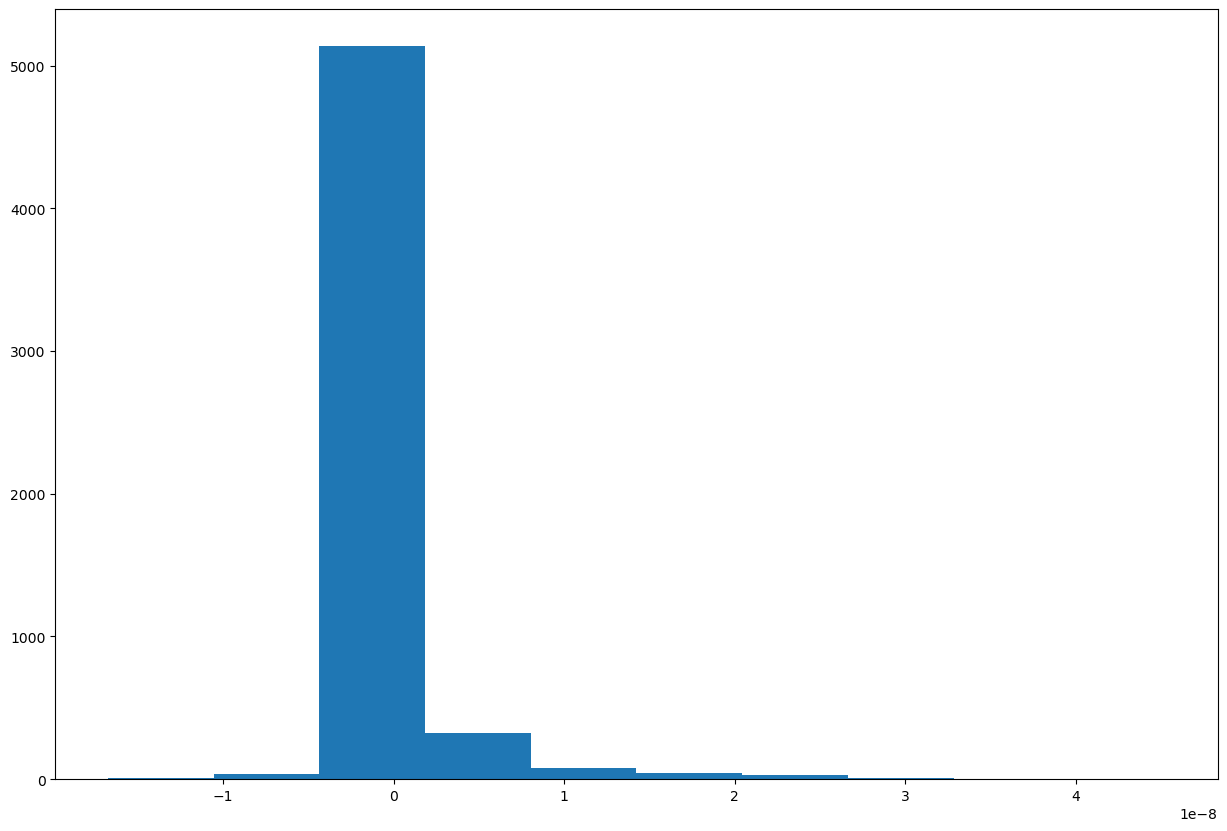

In [86]:
frnt.plot(figsize=(15,10),cmap='coolwarm')

Note the white pixel near 44 N, 83 W. This likely is a `NaN` somehow resulting from the frontogenesis calculation.

The units are in degrees K (or C) per meter per second. Traditionally, we plot frontogenesis on more of a meso- or synoptic scale ... degrees K/C per 100 km per 3 hours. Let's simply multiply by the conversion factor.

In [87]:
# A conversion factor to get frontogensis units of K per 100 km per 3 h
convert_to_per_100km_3h = 1000*100*3600*3
frnt = frnt * convert_to_per_100km_3h

Check the range and scale of values.

In [88]:
frnt.min().values, frnt.max().values

(array(-18.07620716), array(48.84195524))

A scale of 1 (i.e., 1x10^0, AKA 1e0) looks appropriate.

In [89]:
scale = 1e0

### Usually, we wish to avoid plotting the "zero" contour line for diagnostic quantities such as divergence, advection, and frontogenesis. Thus, create two lists of values ... one for negative and one for positive.

In [90]:
frntInc = 3
negFrntContours = np.arange (-18, 0, frntInc)
posFrntContours = np.arange (3, 21, frntInc)

### Now, let's plot frontogenesis on the map. 

Processing 1993-03-14 00:00:00
Processing 1993-03-14 06:00:00
Processing 1993-03-14 12:00:00


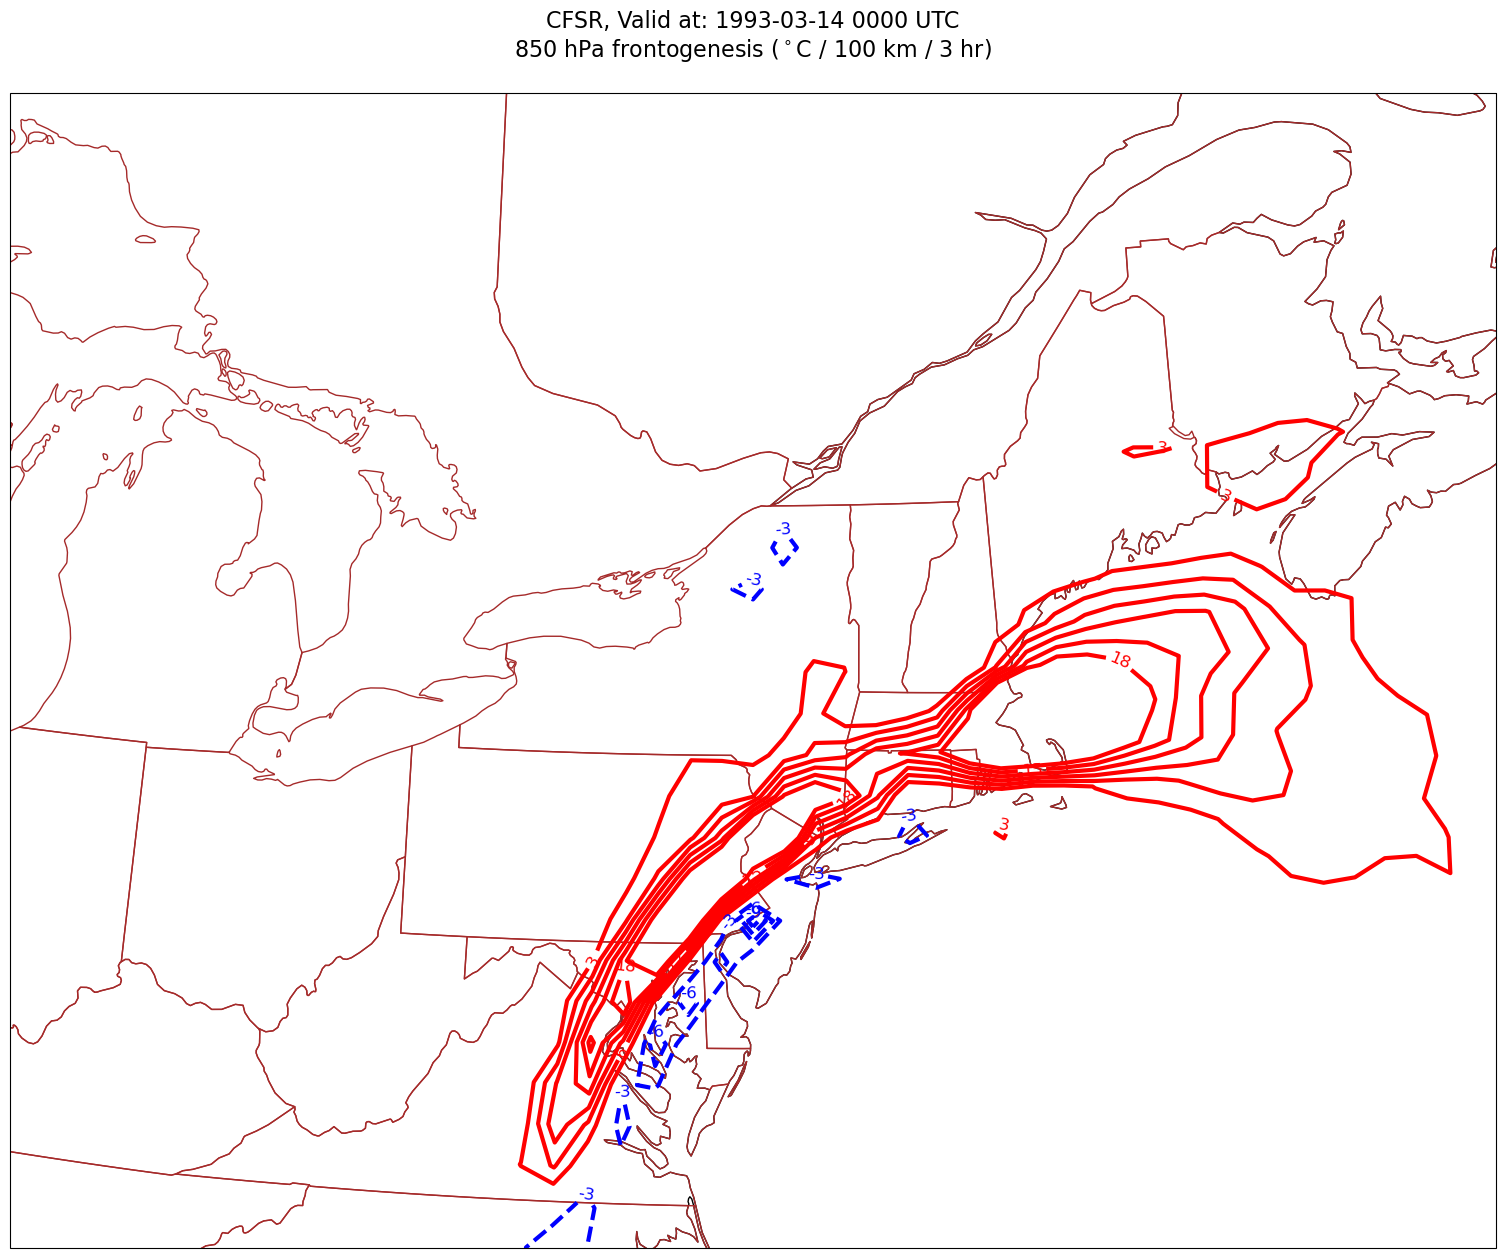

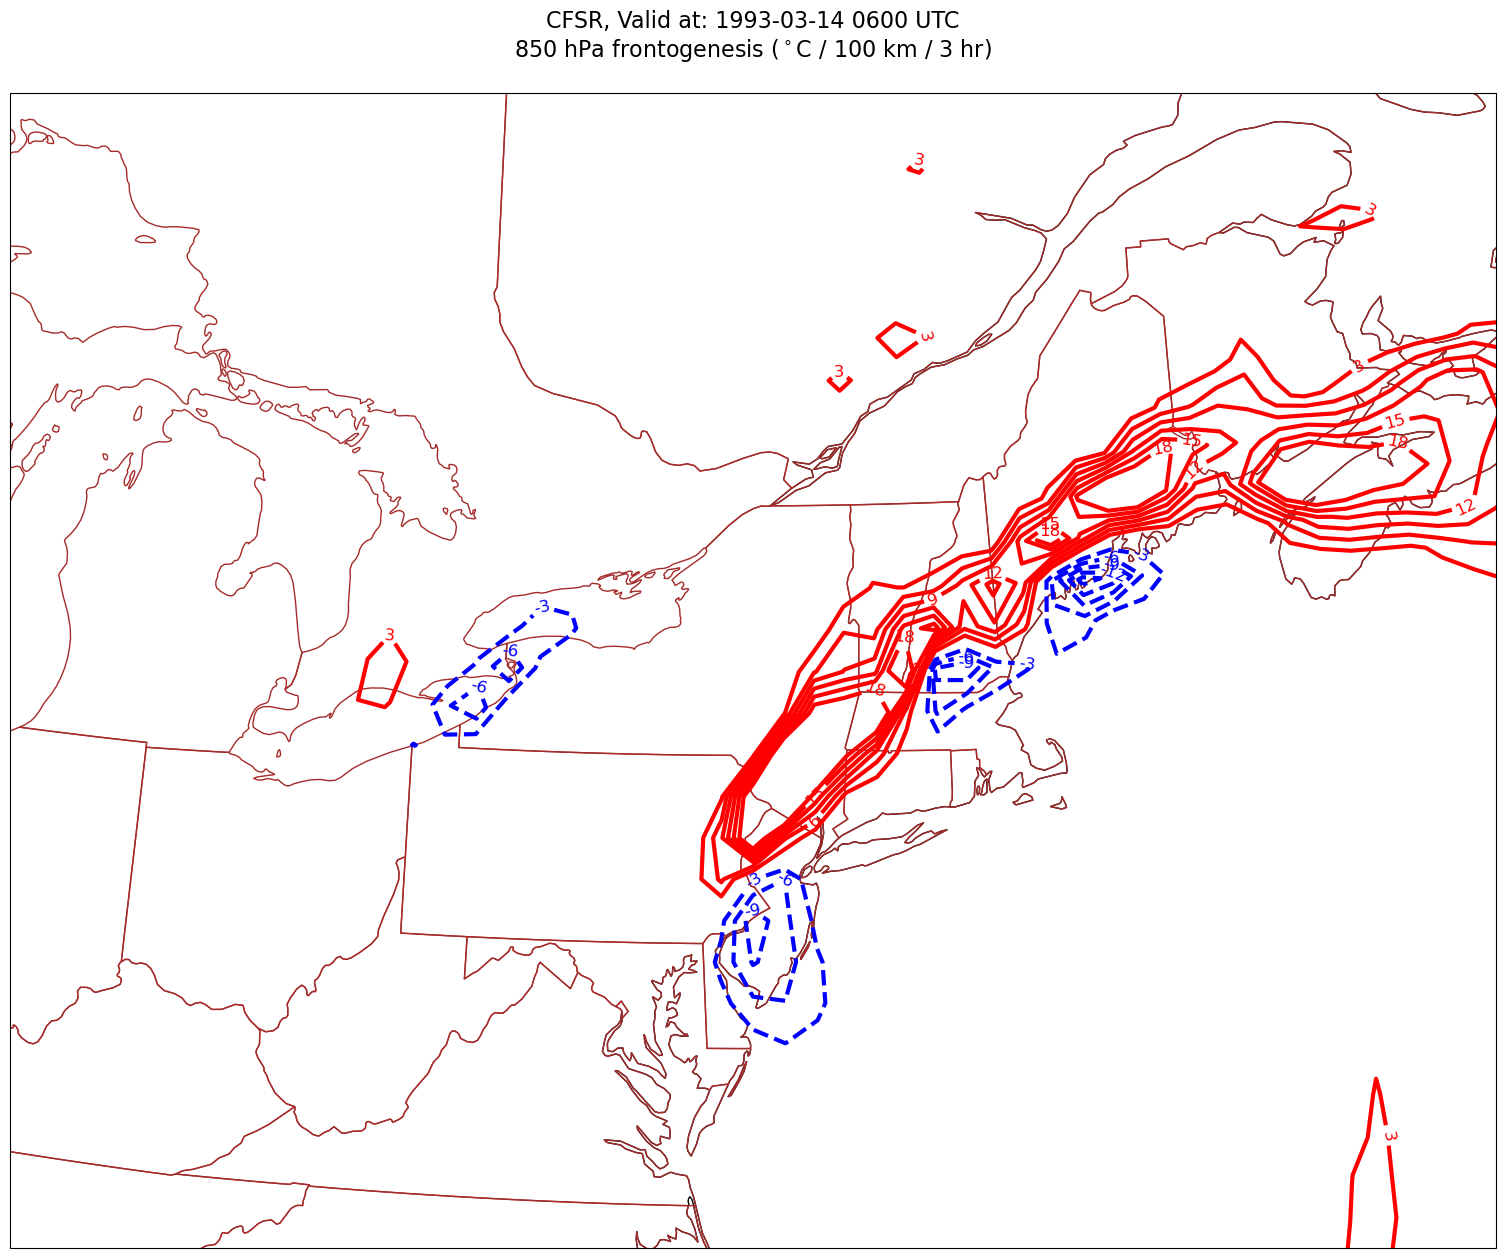

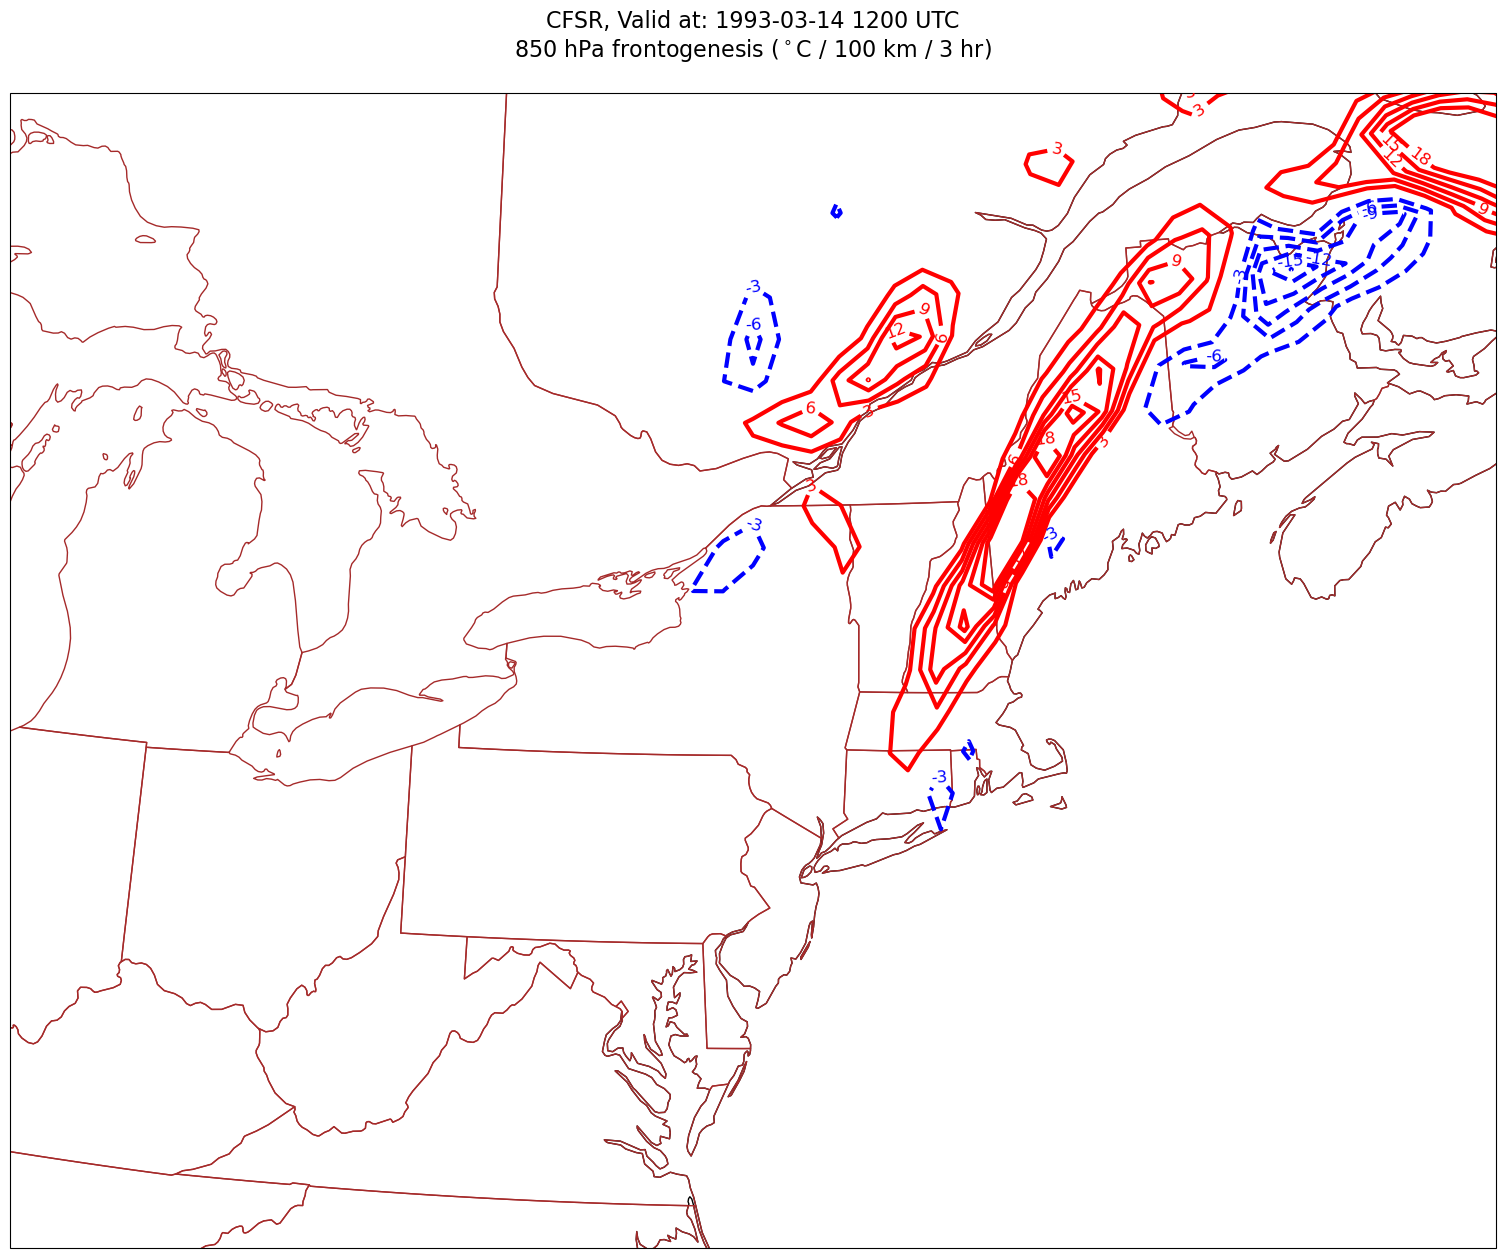

In [91]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = str('CFSR, Valid at: '+ timeStr)
    tl2 = levStr + " hPa frontogenesis ($^\circ$C / 100 km / 3 hr)"
    
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(21,15)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    
    # 1a. Contour lines of warm (positive temperature) advection.
    # Don't forget to multiply by the scaling factor!
    cPosTAdv = ax.contour(lons, lats, frnt.sel(time=time)*scale, levels=posFrntContours, colors='red', linewidths=3, transform=proj_data)
    ax.clabel(cPosTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    # 1b. Contour lines of cold (negative temperature) advection
    cNegTAdv = ax.contour(lons, lats, frnt.sel(time=time)*scale, levels=negFrntContours, colors='blue', linewidths=3, transform=proj_data)
    ax.clabel(cNegTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    title = plt.title(title_line,fontsize=16)
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = timeStrFile + '_CFSR_' + levStr + '_Frnt.png'
    fig.savefig(fileName)


# <span style="color:purple">4. Smooth the diagnostic field.</span>

Use [MetPy's implementation of a Gaussian smoother](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.smooth_gaussian.html).

In [92]:
sigma = 10.0 # this depends on how noisy your data is, adjust as necessary
frntSmth = mpcalc.smooth_gaussian(frnt, sigma)

AttributeError: 'Rectangle' object has no property 'cmap'

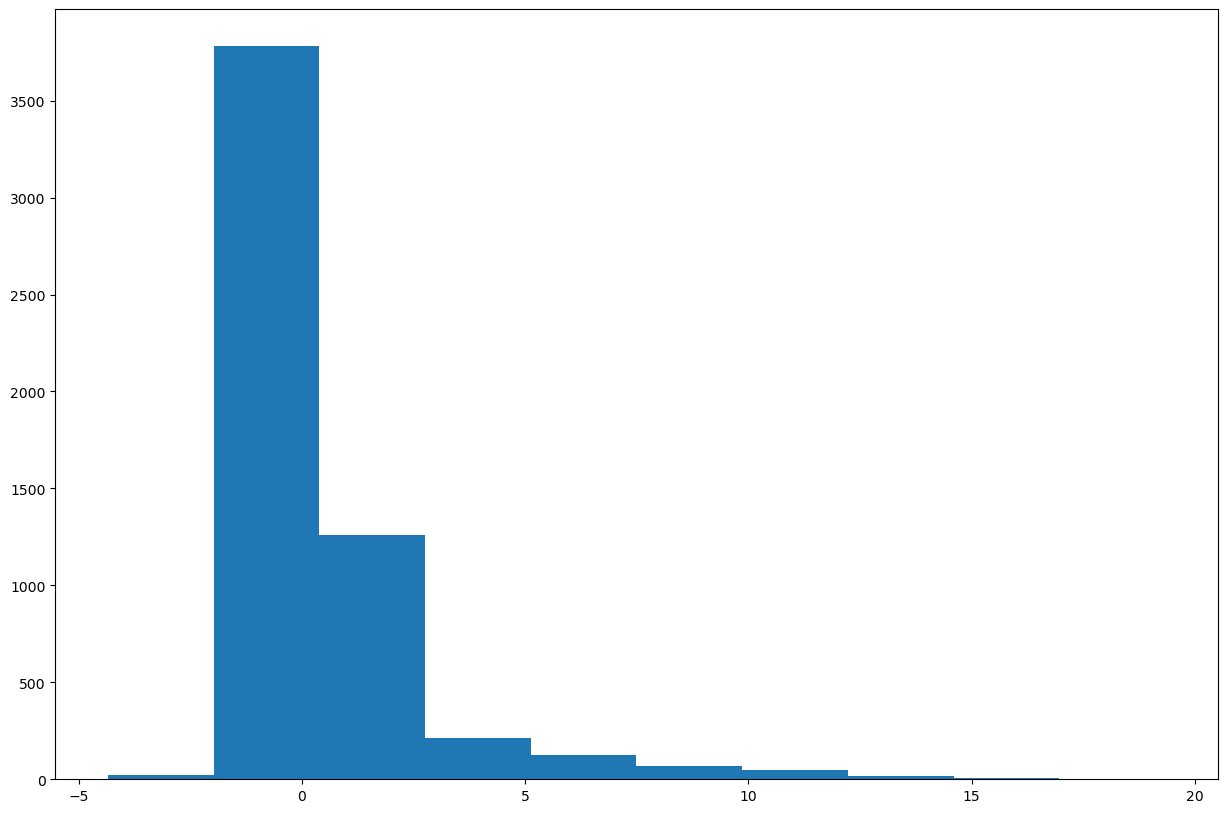

In [93]:
frntSmth.plot(figsize=(15,10),cmap='coolwarm')

Plot the smoothed field.

In [ ]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = str('CFSR, Valid at: '+ timeStr)
    tl2 = levStr + " hPa frontogenesis ($^\circ$C / 100 km / 3 hr)"
    
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(21,15)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    
    # 1a. Contour lines of warm (positive temperature) advection.
    # Don't forget to multiply by the scaling factor!
    cPosTAdv = ax.contour(lons, lats, frntSmth.sel(time=time)*scale, levels=posFrntContours, colors='red', linewidths=3, transform=proj_data)
    ax.clabel(cPosTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    # 1b. Contour lines of cold (negative temperature) advection
    cNegTAdv = ax.contour(lons, lats, frntSmth.sel(time=time)*scale, levels=negFrntContours, colors='blue', linewidths=3, transform=proj_data)
    ax.clabel(cNegTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    title = plt.title(title_line,fontsize=16)
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = timeStrFile + '_CFSR_' + levStr + '_Frnt.png'
    fig.savefig(fileName)
